dSA matching values

In [1]:
from coffea import hist
from coffea.hist.hist_tools import Interval
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward
from uproot_methods import TLorentzVectorArray

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import os
from os.path import join

dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2.json')))
backgrounds_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_v2.json')))

In [3]:
class dsamatchProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        ratio_axis = hist.Bin('ratio', 'max overlap ratio', 20, 0, 1)
        deltar_axis = hist.Bin('dr', 'min $\Delta$R', 20, 0, 1)
        id_axis = hist.Bin('dsaid', 'pass preselection', 2, 0, 2)
        pt_axis = hist.Bin('pt', '$p_T$ [GeV]', 20, 0, 40)
        nchi2_axis = hist.Bin('nchi2', 'normalized $\chi^2$', 20, 0, 10)
        nhit_axis = hist.Bin('nhit', '# of hits', 25, 0, 25)
        self._accumulator = processor.dict_accumulator({
            'dsa': hist.Hist('Counts', dataset_axis, ratio_axis, deltar_axis, id_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            'unmat_dsa': hist.Hist('Counts', dataset_axis, pt_axis, nchi2_axis, nhit_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['dsamuon_p4.fCoordinates.fX'],
                                                 df['dsamuon_p4.fCoordinates.fY'],
                                                 df['dsamuon_p4.fCoordinates.fZ'],
                                                 df['dsamuon_p4.fCoordinates.fT']),
            cschits=df['dsamuon_nValCSCHits'],
            dthits=df['dsamuon_nValDTHits'],
            cscstas=df['dsamuon_nValCSCStas'],
            dtstas=df['dsamuon_nValDTStas'],
            pterr=df['dsamuon_ptErr'],
            normchi2=df['dsamuon_normChi2'],
            maxoverlapratio=df['dsamuon_maxSegmentOverlapRatio'],
            minlocaldr=df['dsamuon_minExtrapolateInnermostLocalDr'],
            selectors=df['dsamuon_selectors'],
        )
        dsaid=((dsamuons.cschits+dsamuons.dthits)>12)&((dsamuons.cscstas+dsamuons.dtstas)>1)&((dsamuons.pterr/dsamuons.pt)<1)
        dsamuons.add_attributes(dsaid=dsaid)
        ismatched = (dsamuons.maxoverlapratio>0.66)|((dsamuons.maxoverlapratio<=0.66)&(dsamuons.minlocaldr<0.3))
        dsamuons.add_attributes(ismatched=ismatched,
                               pfisoloose=((dsamuons.selectors&(1<<7))==(1<<7)))
        
        output['cutflow']['total'] += dsamuons.counts.sum()
        output['cutflow']['passid'] += dsamuons.dsaid.flatten().sum()
        output['cutflow']['passlooseiso'] += dsamuons.pfisoloose.flatten().sum()
        output['cutflow']['matched'] += (dsamuons.dsaid&dsamuons.ismatched).flatten().sum()
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
            charge=df['gen_charge'],
        )
        genmuons = genparticles[np.abs(genparticles.pid)==13]
        
        dsamuons.add_attributes(matchedidx = dsamuons.argmatch(genmuons, deltaRCut=0.2))
        matcheddsa = dsamuons[dsamuons.matchedidx!=-1]
        output['cutflow']['genmatched_total'] += matcheddsa.counts.sum()
        output['cutflow']['genmatched_passid'] += matcheddsa.dsaid.flatten().sum()
        output['cutflow']['genmatched_matched'] += (matcheddsa.dsaid&matcheddsa.ismatched).flatten().sum()
        output['cutflow']['genmatched_passlooseiso'] += matcheddsa.pfisoloose.flatten().sum()
        
        output['dsa'].fill(dataset=dataset, ratio=matcheddsa.maxoverlapratio.flatten(),
                           dr=matcheddsa.minlocaldr.flatten(),
                           dsaid=matcheddsa.dsaid.flatten().astype(int))
        unmatcheddsa = dsamuons[dsamuons.dsaid&(~dsamuons.ismatched)]
        output['unmat_dsa'].fill(dataset=dataset, pt=unmatcheddsa.pt.flatten(),
                                 nchi2=unmatcheddsa.normchi2.flatten(),
                                 nhit=unmatcheddsa.dthits.flatten(),
                                )
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [4]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=dsamatchProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:07<00:00,  1.26items/s]


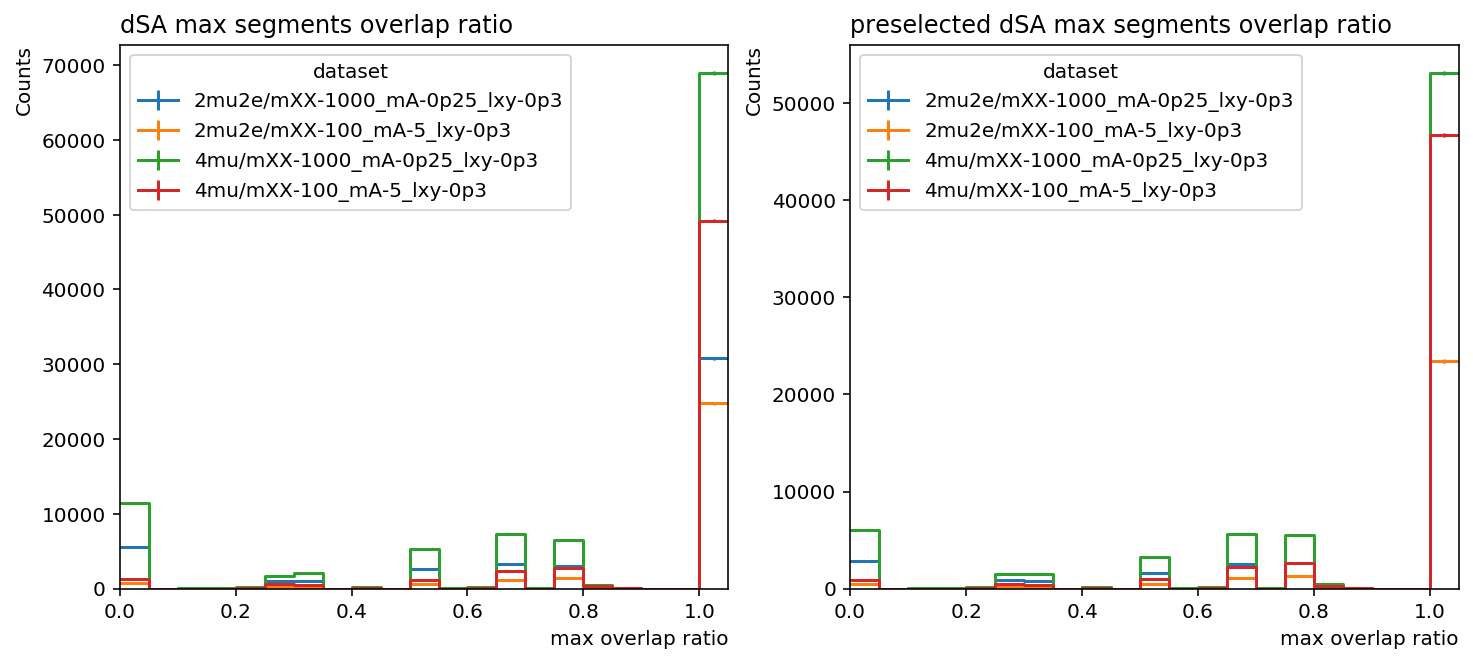

In [9]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
hist.plot1d(output['dsa'].integrate('dr').integrate('dsaid'), overflow='over', overlay='dataset', density=False, ax=axes[0])
hist.plot1d(output['dsa'].integrate('dr').integrate('dsaid', slice(1,2)), overflow='over', overlay='dataset', density=False, ax=axes[1])
axes[0].set_title('dSA max segments overlap ratio', ha='left', x=0)
axes[1].set_title('preselected dSA max segments overlap ratio', ha='left', x=0)
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:477: RuntimeWarning: Reducing along axis <Bin (name=ratio) instance at 0x7fa57d9d4c88>: requested stop 0.66 between bin boundaries, no interpolation is performed
  RuntimeWarning)


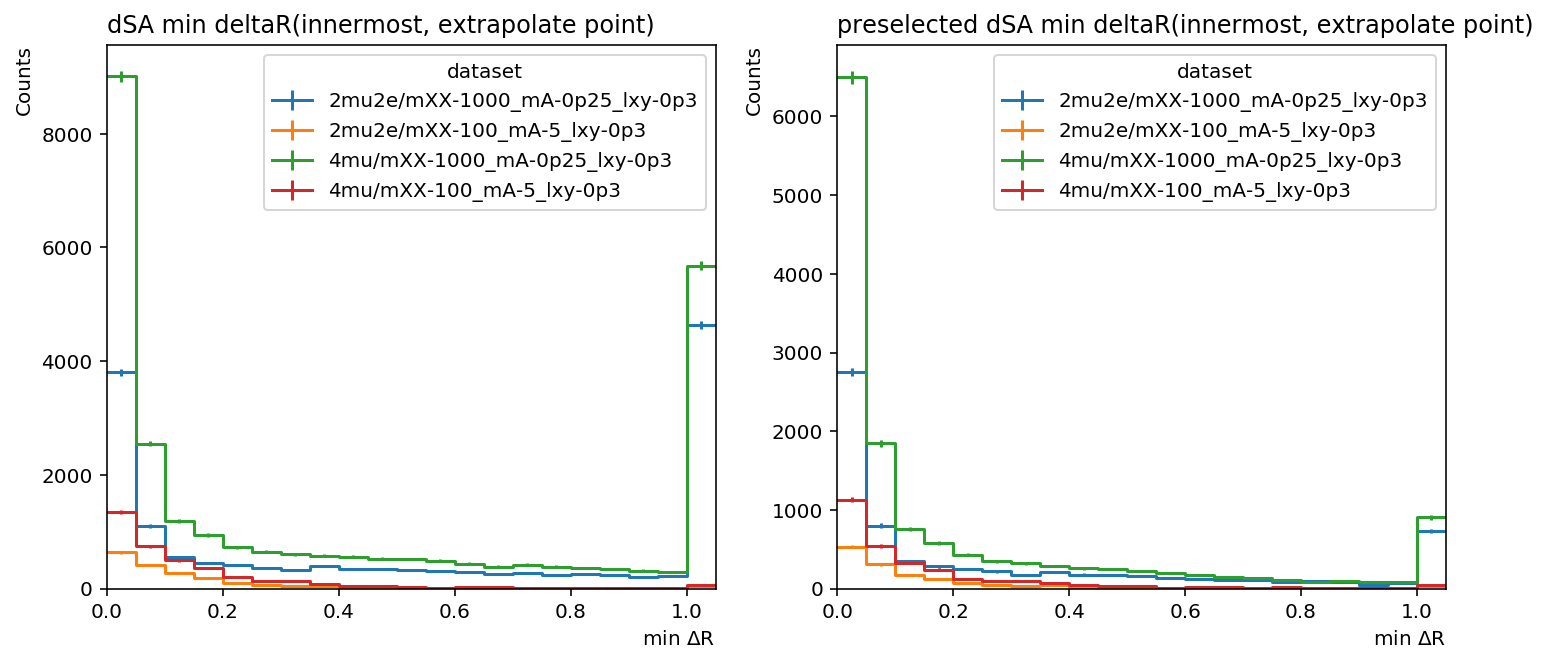

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
hist.plot1d(output['dsa'].integrate('ratio', slice(0, 0.66)).integrate('dsaid'), overlay='dataset', density=False, overflow='over', ax=axes[0])
hist.plot1d(output['dsa'].integrate('ratio', slice(0, 0.66)).integrate('dsaid', slice(1,2)), overlay='dataset', density=False, overflow='over', ax=axes[1])
axes[0].set_title('dSA min deltaR(innermost, extrapolate point)', ha='left', x=0)
axes[1].set_title('preselected dSA min deltaR(innermost, extrapolate point)', ha='left', x=0)
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [11]:
from collections import defaultdict
res = defaultdict(dict)
for d in output['dsa'].identifiers('dataset'):
    h_ = output['dsa'].integrate('dataset', d)
    res[str(d)]['total'] = h_.integrate('ratio', overflow='all').integrate('dr', overflow='all').integrate('dsaid', overflow='all').values()[()]
    res[str(d)]['passid'] = h_.integrate('ratio', overflow='all').integrate('dr', overflow='all').integrate('dsaid', slice(1,2)).values()[()]
    hh_ = h_.integrate('dsaid', slice(1,2))
    res[str(d)]['matched'] = hh_.integrate('dr', overflow='all').integrate('ratio', Interval(0.66, np.inf)).values()[()]\
                            + hh_.integrate('dr', slice(0, 0.3)).integrate('ratio', slice(0, 0.66)).values()[()]

import pandas as pd
df = pd.DataFrame(res).transpose()
df['pass/tot %'] = df['passid']/df['total']*100
df['match/pass %'] = df['matched']/df['passid']*100
display(df)

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:460: RuntimeWarning: Reducing along axis <Bin (name=ratio) instance at 0x7fa57d9d4c88>: requested start 0.66 between bin boundaries, no interpolation is performed
  RuntimeWarning)


,matched,passid,total,pass/tot %,match/pass %
2mu2e/mXX-1000_mA-0p25_lxy-0p3,34126.0,36611.0,54102.0,67.670326,93.212422
2mu2e/mXX-100_mA-5_lxy-0p3,27411.0,27602.0,29504.0,93.553416,99.308021
4mu/mXX-1000_mA-0p25_lxy-0p3,76236.0,79581.0,112127.0,70.973985,95.796735
4mu/mXX-100_mA-5_lxy-0p3,54441.0,54852.0,58595.0,93.612083,99.250711


In [5]:
output['cutflow']

defaultdict_accumulator(int,
                        {'total': 452395,
                         'passid': 300019,
                         'passlooseiso': 363462,
                         'matched': 272019,
                         'genmatched_total': 254328,
                         'genmatched_passid': 198646,
                         'genmatched_matched': 192214,
                         'genmatched_passlooseiso': 225019})

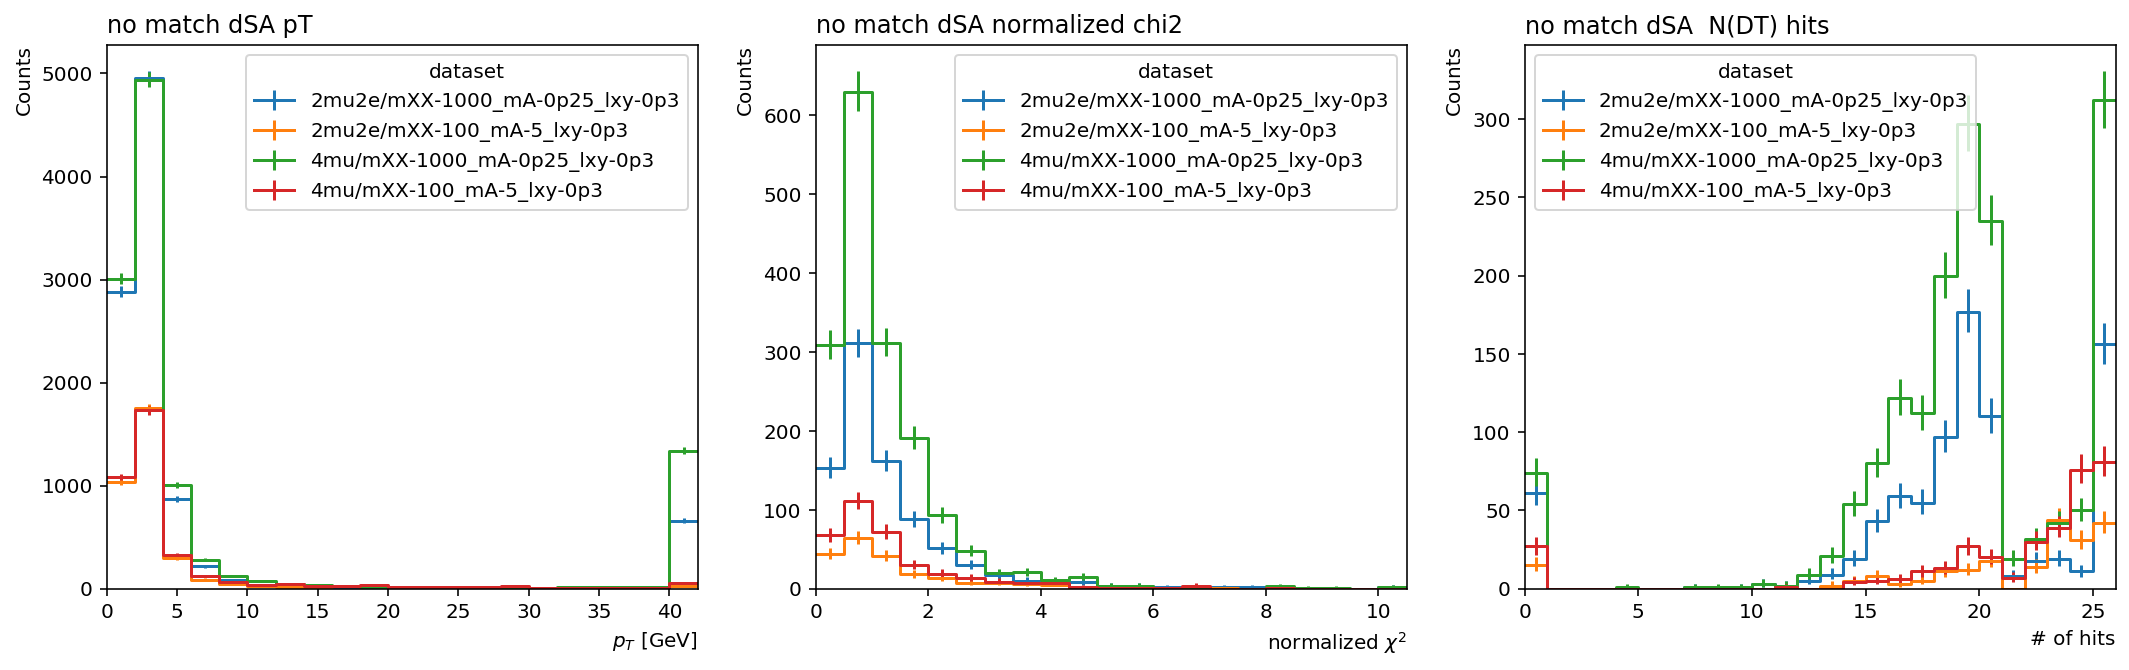

In [13]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
hist.plot1d(output['unmat_dsa'].integrate('nchi2', overflow='all').integrate('nhit', overflow='all'), overlay='dataset', density=False, overflow='over', ax=axes[0])
hist.plot1d(output['unmat_dsa'].integrate('pt', Interval(10, np.inf)).integrate('nhit', overflow='all'), overlay='dataset', density=False, overflow='over', ax=axes[1])
hist.plot1d(output['unmat_dsa'].integrate('pt', Interval(10, np.inf)).integrate('nchi2', overflow='all'), overlay='dataset', density=False, overflow='over', ax=axes[2])
axes[0].set_title('no match dSA pT', ha='left', x=0)
axes[1].set_title('no match dSA normalized chi2', ha='left', x=0)
axes[2].set_title('no match dSA  N(DT) hits', ha='left', x=0)
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

- lxy: 300cm

In [6]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=dsamatchProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:06<00:00,  3.32items/s]


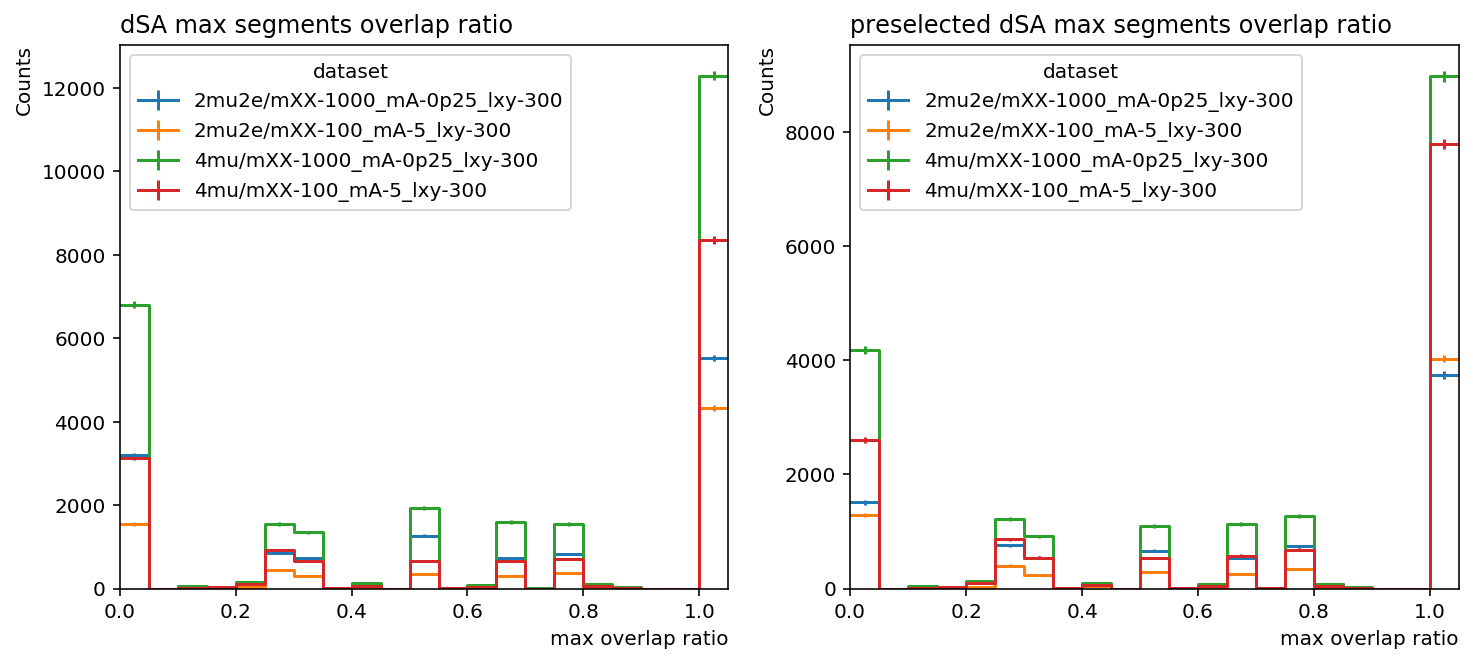

In [15]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
hist.plot1d(output['dsa'].integrate('dr').integrate('dsaid'), overflow='over', overlay='dataset', density=False, ax=axes[0])
hist.plot1d(output['dsa'].integrate('dr').integrate('dsaid', slice(1,2)), overflow='over', overlay='dataset', density=False, ax=axes[1])
axes[0].set_title('dSA max segments overlap ratio', ha='left', x=0)
axes[1].set_title('preselected dSA max segments overlap ratio', ha='left', x=0)
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:477: RuntimeWarning: Reducing along axis <Bin (name=ratio) instance at 0x7fa567085630>: requested stop 0.66 between bin boundaries, no interpolation is performed
  RuntimeWarning)


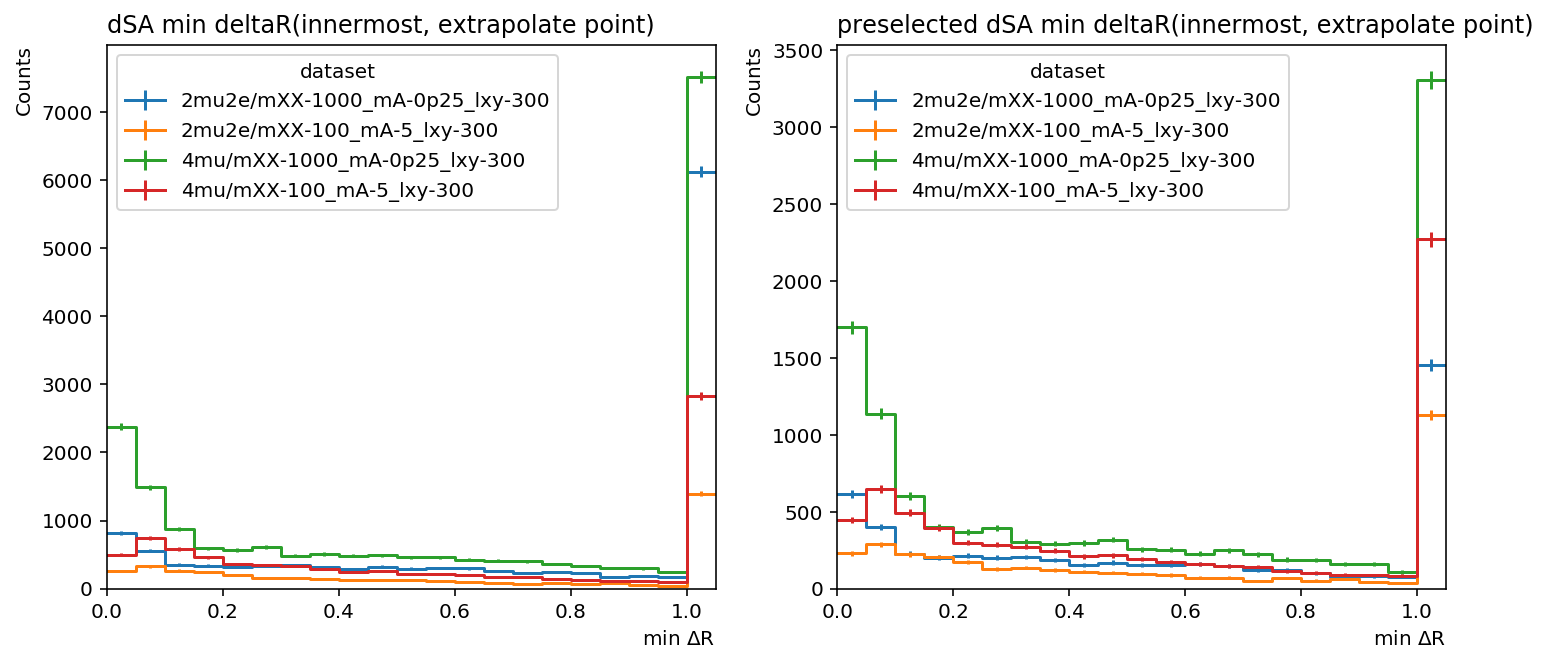

In [16]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
hist.plot1d(output['dsa'].integrate('ratio', slice(0, 0.66)).integrate('dsaid'), overlay='dataset', density=False, overflow='over', ax=axes[0])
hist.plot1d(output['dsa'].integrate('ratio', slice(0, 0.66)).integrate('dsaid', slice(1,2)), overlay='dataset', density=False, overflow='over', ax=axes[1])
axes[0].set_title('dSA min deltaR(innermost, extrapolate point)', ha='left', x=0)
axes[1].set_title('preselected dSA min deltaR(innermost, extrapolate point)', ha='left', x=0)
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [17]:
from collections import defaultdict
res = defaultdict(dict)
for d in output['dsa'].identifiers('dataset'):
    h_ = output['dsa'].integrate('dataset', d)
    res[str(d)]['total'] = h_.integrate('ratio', overflow='all').integrate('dr', overflow='all').integrate('dsaid', overflow='all').values()[()]
    res[str(d)]['passid'] = h_.integrate('ratio', overflow='all').integrate('dr', overflow='all').integrate('dsaid', slice(1,2)).values()[()]
    hh_ = h_.integrate('dsaid', slice(1,2))
    res[str(d)]['matched'] = hh_.integrate('dr', overflow='all').integrate('ratio', Interval(0.66, np.inf)).values()[()]\
                            + hh_.integrate('dr', slice(0, 0.3)).integrate('ratio', slice(0, 0.66)).values()[()]

import pandas as pd
df = pd.DataFrame(res).transpose()
df['pass/tot %'] = df['passid']/df['total']*100
df['match/pass %'] = df['matched']/df['passid']*100
display(df)

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:460: RuntimeWarning: Reducing along axis <Bin (name=ratio) instance at 0x7fa567085630>: requested start 0.66 between bin boundaries, no interpolation is performed
  RuntimeWarning)


,matched,passid,total,pass/tot %,match/pass %
2mu2e/mXX-1000_mA-0p25_lxy-300,11859.0,15213.0,26969.0,56.409211,77.953066
2mu2e/mXX-100_mA-5_lxy-300,11022.0,13255.0,14565.0,91.005836,83.153527
4mu/mXX-1000_mA-0p25_lxy-300,31737.0,38264.0,56910.0,67.235987,82.942191
4mu/mXX-100_mA-5_lxy-300,21682.0,26185.0,28787.0,90.961198,82.803132


In [7]:
output['cutflow']

defaultdict_accumulator(int,
                        {'total': 280563,
                         'passid': 167435,
                         'passlooseiso': 198008,
                         'matched': 126039,
                         'genmatched_total': 127231,
                         'genmatched_passid': 92917,
                         'genmatched_matched': 76300,
                         'genmatched_passlooseiso': 101162})

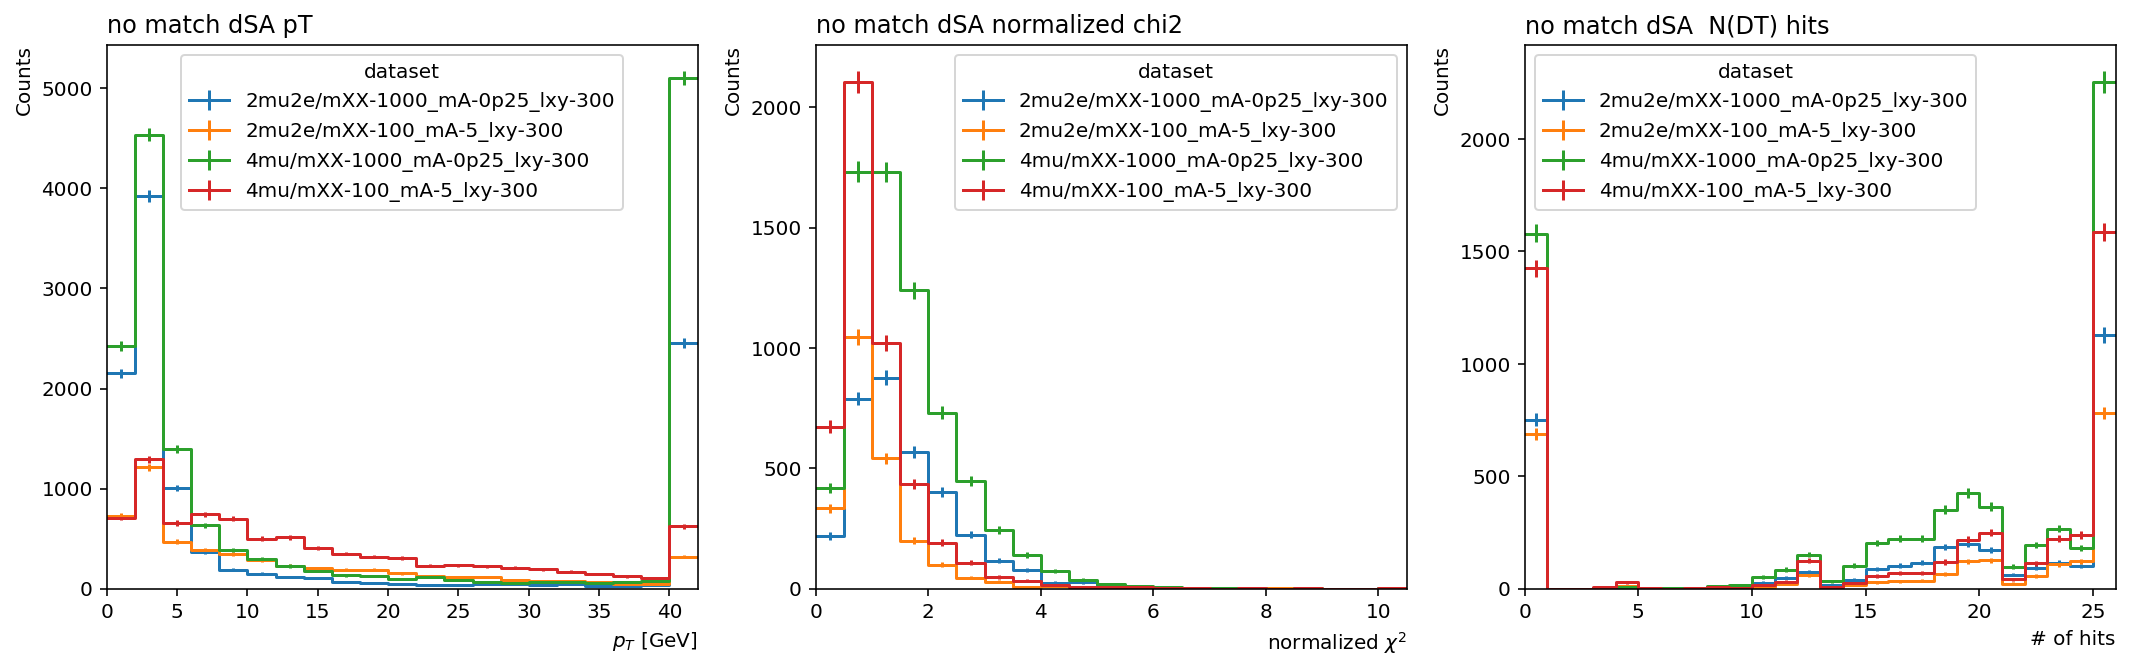

In [19]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
hist.plot1d(output['unmat_dsa'].integrate('nchi2', overflow='all').integrate('nhit', overflow='all'), overlay='dataset', density=False, overflow='over', ax=axes[0])
hist.plot1d(output['unmat_dsa'].integrate('pt', Interval(10, np.inf)).integrate('nhit', overflow='all'), overlay='dataset', density=False, overflow='over', ax=axes[1])
hist.plot1d(output['unmat_dsa'].integrate('pt', Interval(10, np.inf)).integrate('nchi2', overflow='all'), overlay='dataset', density=False, overflow='over', ax=axes[2])
axes[0].set_title('no match dSA pT', ha='left', x=0)
axes[1].set_title('no match dSA normalized chi2', ha='left', x=0)
axes[2].set_title('no match dSA  N(DT) hits', ha='left', x=0)
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## prompt signal subset

In [110]:
class promptsubsetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        localdr_axis = hist.Bin('localdr', '$\Delta$R', 20, 0, 2)
        globaldr_axis = hist.Bin('globaldr', '$\Delta$R', 20, 0, 2)
        dist_axis = hist.Bin('localdist', 'distance', 25, 0, 50)
        sta_axis = hist.Bin('nsta', '# valid MS', 5, 0, 5)
        innersta_axis = hist.Bin('innersta', 'innermost MS', 5, 0, 5)
        pt_axis = hist.Bin('pt', '$p_T$', 50, 0, 100)
        nchi2_axis = hist.Bin('nchi2', 'normalized $\chi^2$', 20, 0, 10)
        nhit_axis = hist.Bin('nhit', '# of hits', 48, 0, 48)
        self._accumulator = processor.dict_accumulator({
            'orphandsas': hist.Hist('Counts', dataset_axis, localdr_axis, globaldr_axis, dist_axis, sta_axis),
            'orphandsasTrue': hist.Hist('Counts', dataset_axis, localdr_axis, globaldr_axis, dist_axis, sta_axis),
            'orphandsas1': hist.Hist('Counts', dataset_axis, innersta_axis),
            
            'orphandsaqual': hist.Hist('counts', dataset_axis, pt_axis, nchi2_axis, nhit_axis),
            'orphandsaqualTrue': hist.Hist('counts', dataset_axis, pt_axis, nchi2_axis, nhit_axis),
            
            'cutbook': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
            vx=df['gen_vtx.fCoordinates.fX'],
            vy=df['gen_vtx.fCoordinates.fY'],
            vz=df['gen_vtx.fCoordinates.fZ'],
            #charge=df['gen_charge'],
        )
        genparticles.add_attributes(vxy=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[np.abs(genparticles.pid)==13]
        
        ## prompt-like events
        promptevents = (genmuons.vxy<.3).all()
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['dsamuon_p4.fCoordinates.fX'],
                                                 df['dsamuon_p4.fCoordinates.fY'],
                                                 df['dsamuon_p4.fCoordinates.fZ'],
                                                 df['dsamuon_p4.fCoordinates.fT']),
            cschits=df['dsamuon_nValCSCHits'],
            dthits=df['dsamuon_nValDTHits'],
            cscstas=df['dsamuon_nValCSCStas'],
            dtstas=df['dsamuon_nValDTStas'],
            pterr=df['dsamuon_ptErr'],
            normchi2=df['dsamuon_normChi2'],
            maxoverlapratio=df['dsamuon_maxSegmentOverlapRatio'],
            minlocaldr=df['dsamuon_minExtrapolateInnermostLocalDr'],
            minlocaldist=df['dsamuon_minExtrapolateInnermostLocalDiff'],
            minglobaldr=df['dsamuon_minGlobalDeltaR'],
            innermostSta=df['dsamuon_innermostSta'],
        )
        dsaid=((dsamuons.cschits+dsamuons.dthits)>12)&((dsamuons.cscstas+dsamuons.dtstas)>1)&((dsamuons.pterr/dsamuons.pt)<1)
        dsamuons.add_attributes(dsaid=dsaid)
        ismatched = (dsamuons.maxoverlapratio>0.66)|((dsamuons.maxoverlapratio<=0.66)&(dsamuons.minlocaldr<0.3)|(dsamuons.minglobaldr<0.3))
        dsamuons.add_attributes(ismatched=ismatched)
        dsamuons.add_attributes(matchedidx = dsamuons.argmatch(genmuons, deltaRCut=0.3))
        
        orphandsas = dsamuons[dsamuons.dsaid&(~dsamuons.ismatched)&(dsamuons.pt>10)][promptevents]
        
        output['orphandsas'].fill(dataset=dataset, localdist=orphandsas.minlocaldist.flatten(),
                                 localdr=orphandsas.minlocaldr.flatten(),
                                 globaldr=orphandsas.minglobaldr.flatten(),
                                 nsta=(orphandsas.cscstas+orphandsas.dtstas).flatten())
        orphandsas_t = orphandsas[(orphandsas.matchedidx!=-1)]
        output['orphandsasTrue'].fill(dataset=dataset, localdist=orphandsas_t.minlocaldist.flatten(),
                                 localdr=orphandsas_t.minlocaldr.flatten(),
                                 globaldr=orphandsas_t.minglobaldr.flatten(),
                                 nsta=(orphandsas_t.cscstas+orphandsas_t.dtstas).flatten())
        output['orphandsas1'].fill(dataset=dataset, innersta=orphandsas.innermostSta.flatten())
        
        unmatcheddsa = dsamuons[dsamuons.dsaid&(~dsamuons.ismatched)]
        output['orphandsaqual'].fill(dataset=dataset, pt=orphandsas.pt.flatten(),
                                 nchi2=orphandsas.normchi2.flatten(),
                                 nhit=orphandsas.dthits.flatten(),
                                )
        output['orphandsaqualTrue'].fill(dataset=dataset, pt=orphandsas_t.pt.flatten(),
                                 nchi2=orphandsas_t.normchi2.flatten(),
                                 nhit=orphandsas_t.dthits.flatten(),
                                )
        
        output['cutbook']['total'] += orphandsas.counts.sum()
        output['cutbook']['genmatched'] += orphandsas[(orphandsas.matchedidx!=-1)].counts.sum()
        output['cutbook']['tightMS'] += orphandsas[(orphandsas.matchedidx!=-1)&(orphandsas.innermostSta==1)].counts.sum()
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [111]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=promptsubsetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:07<00:00,  2.84items/s]


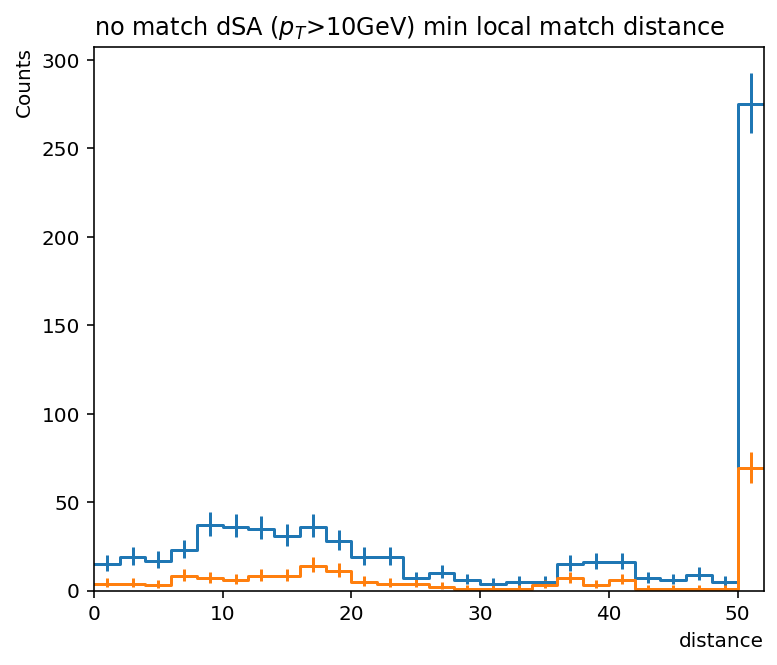

In [106]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['orphandsas'].sum('dataset', 'localdr', 'globaldr', 'nsta', overflow='all'), ax=ax, overflow='over')
hist.plot1d(output['orphandsasTrue'].sum('dataset', 'localdr', 'globaldr', 'nsta', overflow='all'), ax=ax, overflow='over', clear=False)

ax.set_title('no match dSA ($p_T$>10GeV) min local match distance', ha='left', x=0)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

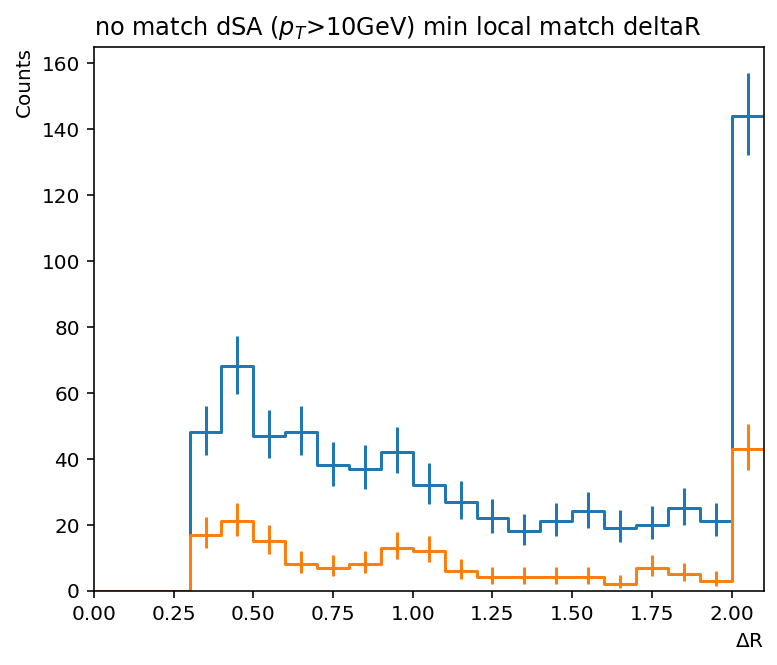

In [105]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['orphandsas'].sum('dataset', 'localdist', 'globaldr', 'nsta', overflow='all'), ax=ax, overflow='over')
hist.plot1d(output['orphandsasTrue'].sum('dataset', 'localdist', 'globaldr', 'nsta', overflow='all'), ax=ax, overflow='over', clear=False)

ax.set_title('no match dSA ($p_T$>10GeV) min local match deltaR', ha='left', x=0)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

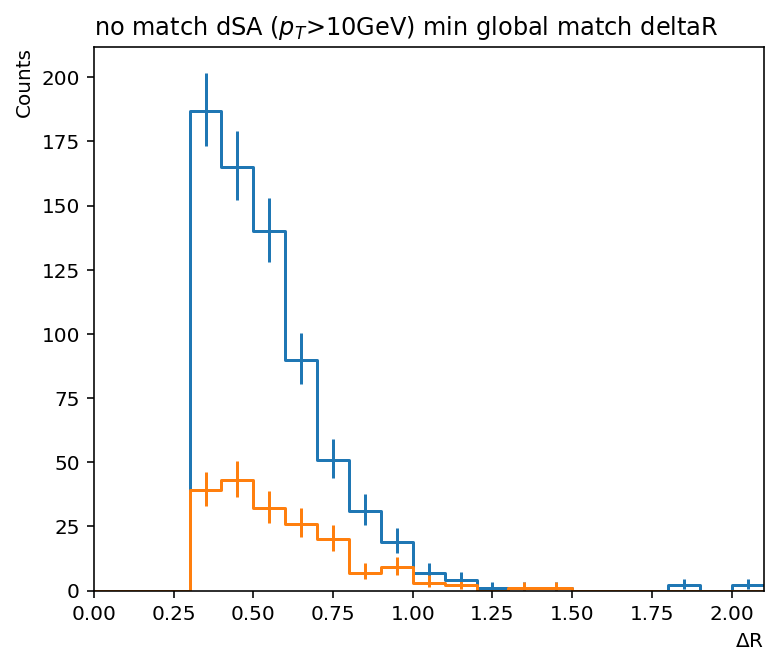

In [103]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['orphandsas'].sum('dataset', 'localdr', 'localdist', 'nsta', overflow='all'), ax=ax, overflow='over')
hist.plot1d(output['orphandsasTrue'].sum('dataset', 'localdr', 'localdist', 'nsta', overflow='all'), ax=ax, overflow='over', clear=False)

ax.set_title('no match dSA ($p_T$>10GeV) min global match deltaR', ha='left', x=0)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

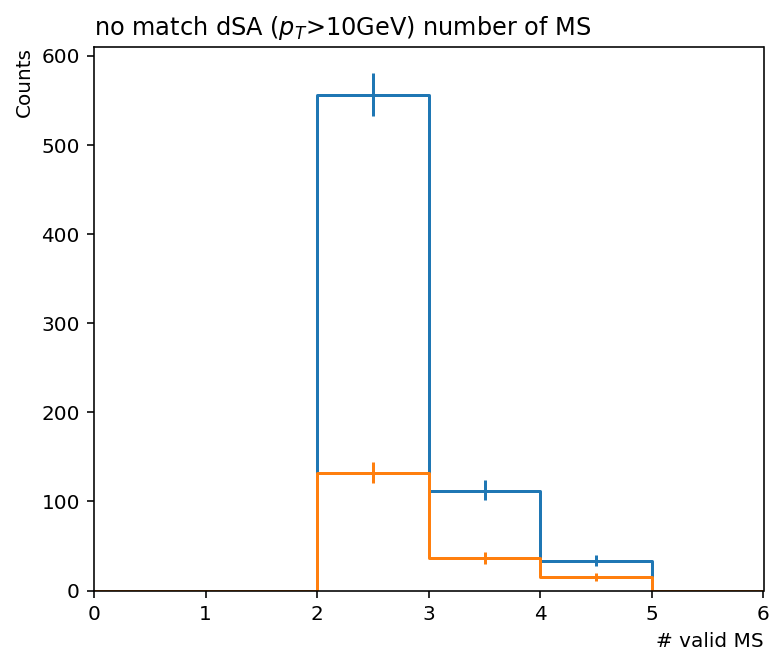

In [104]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['orphandsas'].sum('dataset', 'localdr', 'localdist', 'globaldr', overflow='all'), ax=ax, overflow='over')
hist.plot1d(output['orphandsasTrue'].sum('dataset', 'localdr', 'localdist', 'globaldr', overflow='all'), ax=ax, overflow='over', clear=False)

ax.set_title('no match dSA ($p_T$>10GeV) number of MS', ha='left', x=0)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [102]:
output['cutbook']

defaultdict_accumulator(int, {'total': 701, 'genmatched': 183, 'tightMS': 123})

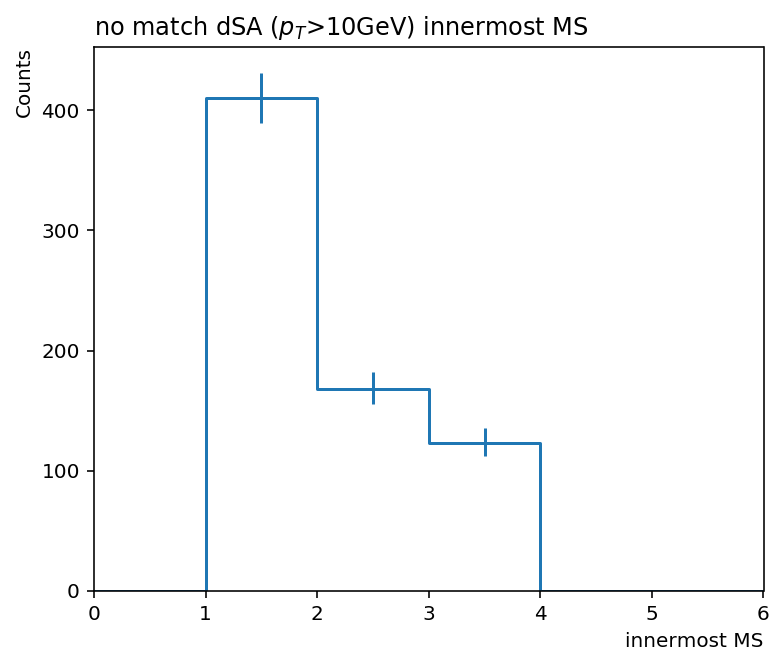

In [107]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['orphandsas1'].sum('dataset', overflow='all'), ax=ax, overflow='over')

ax.set_title('no match dSA ($p_T$>10GeV) innermost MS', ha='left', x=0)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

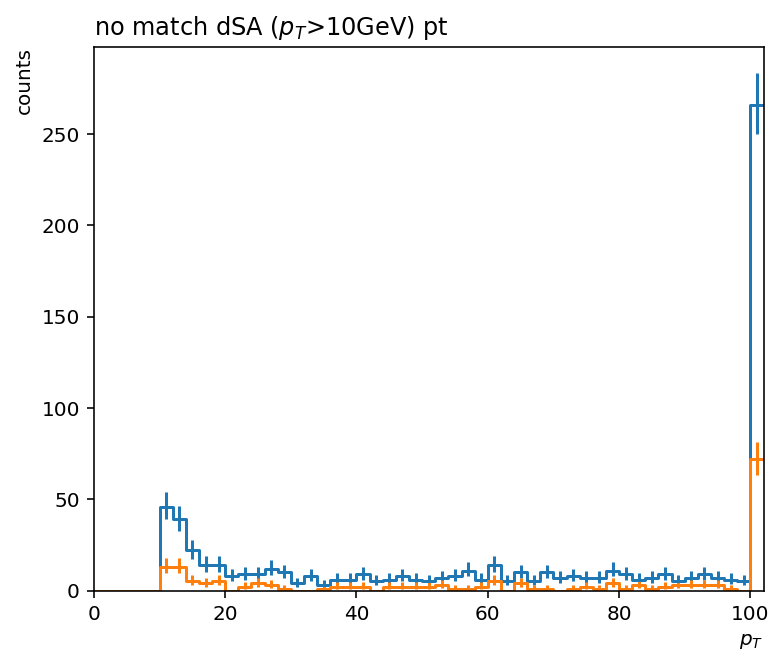

In [112]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['orphandsaqual'].sum('dataset', 'nchi2', 'nhit', overflow='all'), ax=ax, overflow='over')
hist.plot1d(output['orphandsaqualTrue'].sum('dataset', 'nchi2', 'nhit', overflow='all'), ax=ax, overflow='over', clear=False)

ax.set_title('no match dSA ($p_T$>10GeV) pt', ha='left', x=0)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

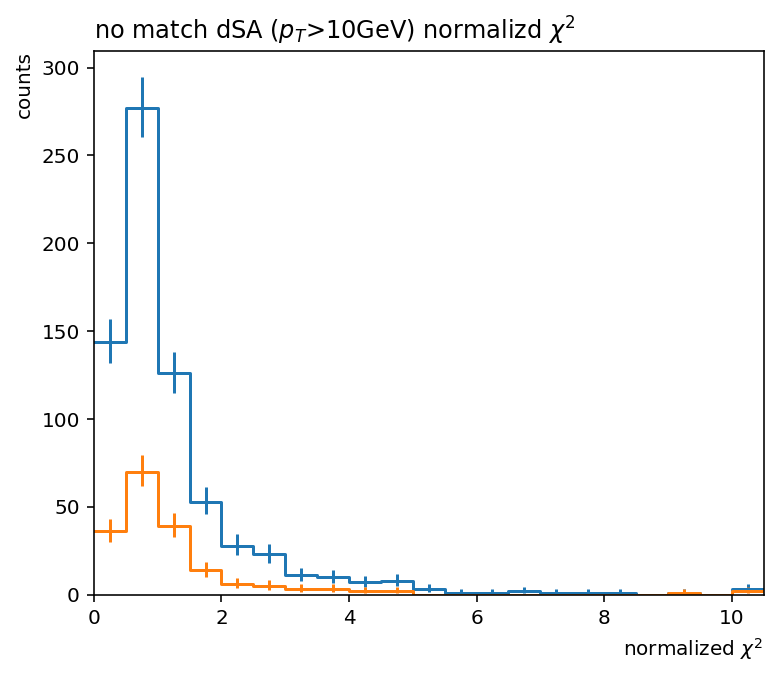

In [114]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['orphandsaqual'].sum('dataset', 'pt', 'nhit', overflow='all'), ax=ax, overflow='over')
hist.plot1d(output['orphandsaqualTrue'].sum('dataset', 'pt', 'nhit', overflow='all'), ax=ax, overflow='over', clear=False)

ax.set_title('no match dSA ($p_T$>10GeV) normalizd $\chi^2$', ha='left', x=0)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

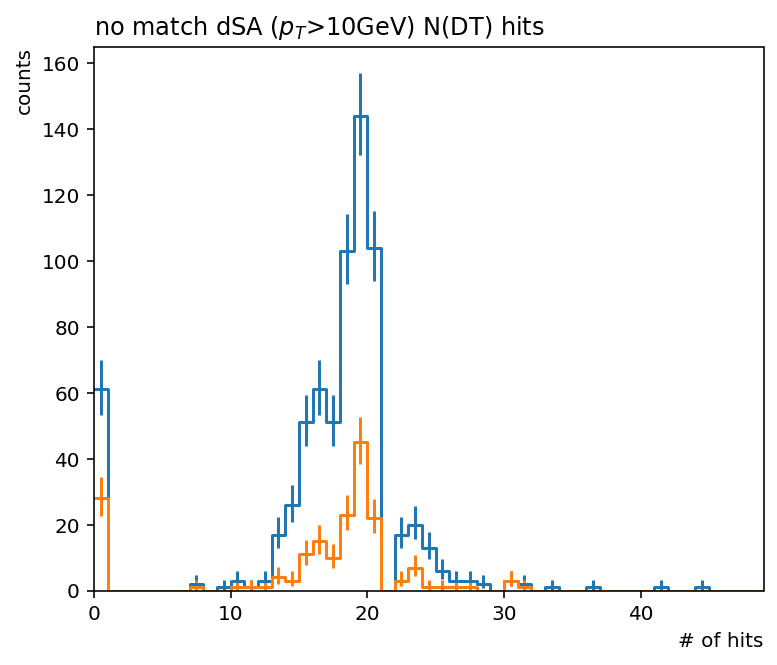

In [115]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['orphandsaqual'].sum('dataset', 'nchi2', 'pt', overflow='all'), ax=ax, overflow='over')
hist.plot1d(output['orphandsaqualTrue'].sum('dataset', 'nchi2', 'pt', overflow='all'), ax=ax, overflow='over', clear=False)

ax.set_title('no match dSA ($p_T$>10GeV) N(DT) hits', ha='left', x=0)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

# PFMuons

In [161]:
class pfMuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        self._accumulator = processor.dict_accumulator({
            'cutbook': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
            vx=df['gen_vtx.fCoordinates.fX'],
            vy=df['gen_vtx.fCoordinates.fY'],
            vz=df['gen_vtx.fCoordinates.fZ'],
        )
        genparticles.add_attributes(vxy=np.hypot(genparticles.vx, genparticles.vy))
        
        genmuons = genparticles[np.abs(genparticles.pid)==13]
        genmuonsprompt = genmuons[genmuons.vxy<0.3]
    
        ## recomuons/pfmuons
        recomuons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['muon_p4.fCoordinates.fX'],
                                                 df['muon_p4.fCoordinates.fY'],
                                                 df['muon_p4.fCoordinates.fZ'],
                                                 df['muon_p4.fCoordinates.fT']),
            ispfmuon=df['muon_isPFMuon'],
        )
        pfmuons = recomuons[recomuons.ispfmuon]
        
        foundMatchedPfMuon = genmuonsprompt.match(recomuons, deltaRCut=0.3)
        
        ## dsamuons
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['dsamuon_p4.fCoordinates.fX'],
                                                 df['dsamuon_p4.fCoordinates.fY'],
                                                 df['dsamuon_p4.fCoordinates.fZ'],
                                                 df['dsamuon_p4.fCoordinates.fT']),
            cschits=df['dsamuon_nValCSCHits'],
            dthits=df['dsamuon_nValDTHits'],
            cscstas=df['dsamuon_nValCSCStas'],
            dtstas=df['dsamuon_nValDTStas'],
            pterr=df['dsamuon_ptErr'],
            normchi2=df['dsamuon_normChi2'],
            maxoverlapratio=df['dsamuon_maxSegmentOverlapRatio'],
            minlocaldr=df['dsamuon_minExtrapolateInnermostLocalDr'],
            minlocaldist=df['dsamuon_minExtrapolateInnermostLocalDiff'],
            minglobaldr=df['dsamuon_minGlobalDeltaR'],
            innermostSta=df['dsamuon_innermostSta'],
        )
        dsaid=((dsamuons.cschits+dsamuons.dthits)>12)&((dsamuons.cscstas+dsamuons.dtstas)>1)&((dsamuons.pterr/dsamuons.pt)<1)
        dsamuons.add_attributes(dsaid=dsaid)
        ismatched = (dsamuons.maxoverlapratio>0.66)|((dsamuons.maxoverlapratio<=0.66)&(dsamuons.minlocaldr<0.3)|(dsamuons.minglobaldr<0.3))
        dsamuons.add_attributes(ismatched=ismatched)
        
        orphandsas = dsamuons[dsamuons.dsaid&(~dsamuons.ismatched)&(dsamuons.pt>10)]
        foundMatchedOrphanDsa = genmuonsprompt.match(orphandsas, deltaRCut=0.3)
        
        
        output['cutbook']['total'] += genmuonsprompt.counts.sum()
        output['cutbook']['pfmatched'] += genmuonsprompt[foundMatchedPfMuon].counts.sum()
        output['cutbook']['orphandsamatched'] += genmuonsprompt[(~foundMatchedPfMuon)&(foundMatchedOrphanDsa)].counts.sum()
        
        return output
    
    def postprocess(self, acc):
        return acc

In [162]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=pfMuonProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:07<00:00,  2.85items/s]


In [163]:
output['cutbook']

defaultdict_accumulator(int,
                        {'total': 219162,
                         'pfmatched': 218778,
                         'orphandsamatched': 78})

<hr/>

# backgrounds (QCD-Pt120-170)

In [192]:
class dsaqualprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        pt_axis = hist.Bin('pt', '$p_T$ [GeV]', 20, 0, 40)
        nchi2_axis = hist.Bin('nchi2', 'normalized $\chi^2$', 20, 0, 10)
        nhit_axis = hist.Bin('nhit', '# of hits', 48, 0, 48)
        localdiff_axis = hist.Bin('localdist', 'local distance', 50, 0, 50)
        localdr_axis = hist.Bin('localdr', 'local deltaR', 25, 0, 2.5)
        sta_axis = hist.Bin('sta', 'innermost stations', 4, 0, 4)
        self._accumulator = processor.dict_accumulator({
            'cutflow': processor.defaultdict_accumulator(int),
            'unmat_dsa': hist.Hist('Counts', dataset_axis, pt_axis, nchi2_axis, nhit_axis),
            'dsalocal': hist.Hist('Counts', dataset_axis, localdiff_axis, localdr_axis, sta_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['dsamuon_p4.fCoordinates.fX'],
                                                 df['dsamuon_p4.fCoordinates.fY'],
                                                 df['dsamuon_p4.fCoordinates.fZ'],
                                                 df['dsamuon_p4.fCoordinates.fT']),
            cschits=df['dsamuon_nValCSCHits'],
            dthits=df['dsamuon_nValDTHits'],
            cscstas=df['dsamuon_nValCSCStas'],
            dtstas=df['dsamuon_nValDTStas'],
            pterr=df['dsamuon_ptErr'],
            normchi2=df['dsamuon_normChi2'],
            maxoverlapratio=df['dsamuon_maxSegmentOverlapRatio'],
            localmindr=df['dsamuon_minExtrapolateInnermostLocalDr'],
            localmindist=df['dsamuon_minExtrapolateInnermostLocalDiff'],
            globalmindr=df['dsamuon_minGlobalDeltaR'],
            innermoststa=df['dsamuon_innermostSta'],
        )
        dsaid=((dsamuons.cschits+dsamuons.dthits)>12)&((dsamuons.cscstas+dsamuons.dtstas)>1)&((dsamuons.pterr/dsamuons.pt)<1)
        dsamuons.add_attributes(dsaid=dsaid)
        ismatched = (dsamuons.maxoverlapratio>0.66)|((dsamuons.maxoverlapratio<=0.66)&(dsamuons.localmindr<0.3)|(dsamuons.globalmindr<0.3))
        dsamuons.add_attributes(ismatched=ismatched)
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
        )
        genmuons = genparticles[np.abs(genparticles.pid)==13]
        
        dsamuons.add_attributes(matchedidx = dsamuons.argmatch(genmuons, deltaRCut=0.2))
        
        output['cutflow']['total'] += dsamuons.counts.sum()
        output['cutflow']['passid'] += dsamuons.dsaid.flatten().sum()
        output['cutflow']['matched'] += (dsamuons.dsaid&dsamuons.ismatched).flatten().sum()
        output['cutflow']['unmatched'] += (dsamuons.dsaid&(~dsamuons.ismatched)).flatten().sum()
        output['cutflow']['pt>10'] += (dsamuons.dsaid&(~dsamuons.ismatched)&(dsamuons.pt>10)).flatten().sum()
        output['cutflow']['is_cscmuon'] += (dsamuons.dsaid&(~dsamuons.ismatched)&(dsamuons.pt>10)&(dsamuons.dthits==0)).flatten().sum()
        output['cutflow']['is_dtmuon'] += (dsamuons.dsaid&(~dsamuons.ismatched)&(dsamuons.pt>10)&(dsamuons.cschits==0)).flatten().sum()
        
        output['cutflow']['pt>10&NMS=2'] += (dsamuons.dsaid&(~dsamuons.ismatched)&(dsamuons.pt>10)&((dsamuons.cscstas+dsamuons.dtstas)==2)&(dsamuons.innermoststa==1)).flatten().sum()
        output['cutflow']['pt>10&NDT<19'] += (dsamuons.dsaid&(~dsamuons.ismatched)&(dsamuons.pt>10)&(dsamuons.cschits==0)&(dsamuons.dthits<=18)).flatten().sum()
        
        unmatcheddsa = dsamuons[dsamuons.dsaid&(~dsamuons.ismatched)]
        output['unmat_dsa'].fill(dataset=dataset, pt=unmatcheddsa.pt.flatten(),
                                 nchi2=unmatcheddsa.normchi2.flatten(),
                                 nhit=unmatcheddsa.dthits.flatten(),
                                )
        
        output['cutflow']['matchedToGen'] += (unmatcheddsa.matchedidx!=-1).flatten().sum()
        output['cutflow']['matchedToGen&pT>10'] += ((unmatcheddsa.matchedidx!=-1)&(unmatcheddsa.pt>10)).flatten().sum()
        
        output['dsalocal'].fill(dataset=dataset,
                                localdist=unmatcheddsa[unmatcheddsa.pt>10.].localmindist.flatten(),
                               localdr=unmatcheddsa[unmatcheddsa.pt>10.].localmindr.flatten(),
                               sta=unmatcheddsa[unmatcheddsa.pt>10.].innermoststa.flatten())
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [193]:
dataset = backgrounds_['QCD']
output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=dsaqualprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 118/118 [00:18<00:00,  6.53items/s]


In [194]:
pd.Series(dict(output['cutflow']))

total                 182504
passid                133007
matched               124307
unmatched               8700
pt>10                    247
is_cscmuon                53
is_dtmuon                190
pt>10&NMS=2               87
pt>10&NDT<19              55
matchedToGen             366
matchedToGen&pT>10        40
dtype: int64

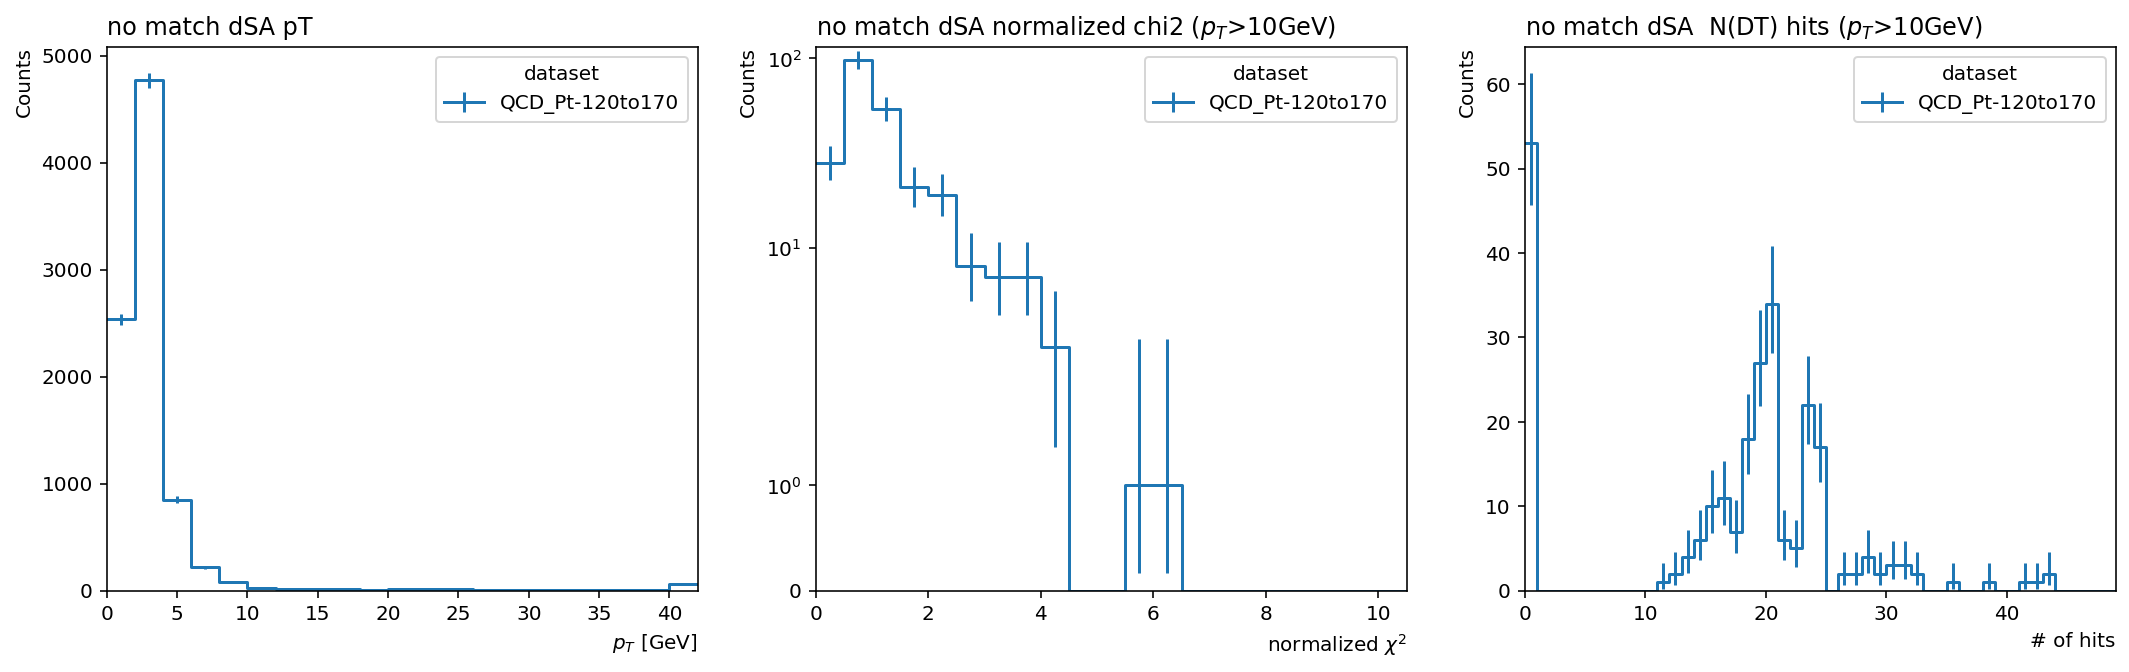

In [176]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
hist.plot1d(output['unmat_dsa'].sum('nchi2', 'nhit', overflow='all'), overlay='dataset', density=False, overflow='over', ax=axes[0])
hist.plot1d(output['unmat_dsa'].integrate('pt', Interval(10, np.inf)).integrate('nhit', overflow='all'), overlay='dataset', density=False, overflow='over', ax=axes[1])
hist.plot1d(output['unmat_dsa'].integrate('pt', Interval(10, np.inf)).integrate('nchi2', overflow='all'), overlay='dataset', density=False, overflow='over', ax=axes[2])
axes[0].set_title('no match dSA pT', ha='left', x=0)
axes[1].set_title('no match dSA normalized chi2 ($p_T$>10GeV)', ha='left', x=0)
axes[1].set_yscale('symlog')
axes[2].set_title('no match dSA  N(DT) hits ($p_T$>10GeV)', ha='left', x=0)
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

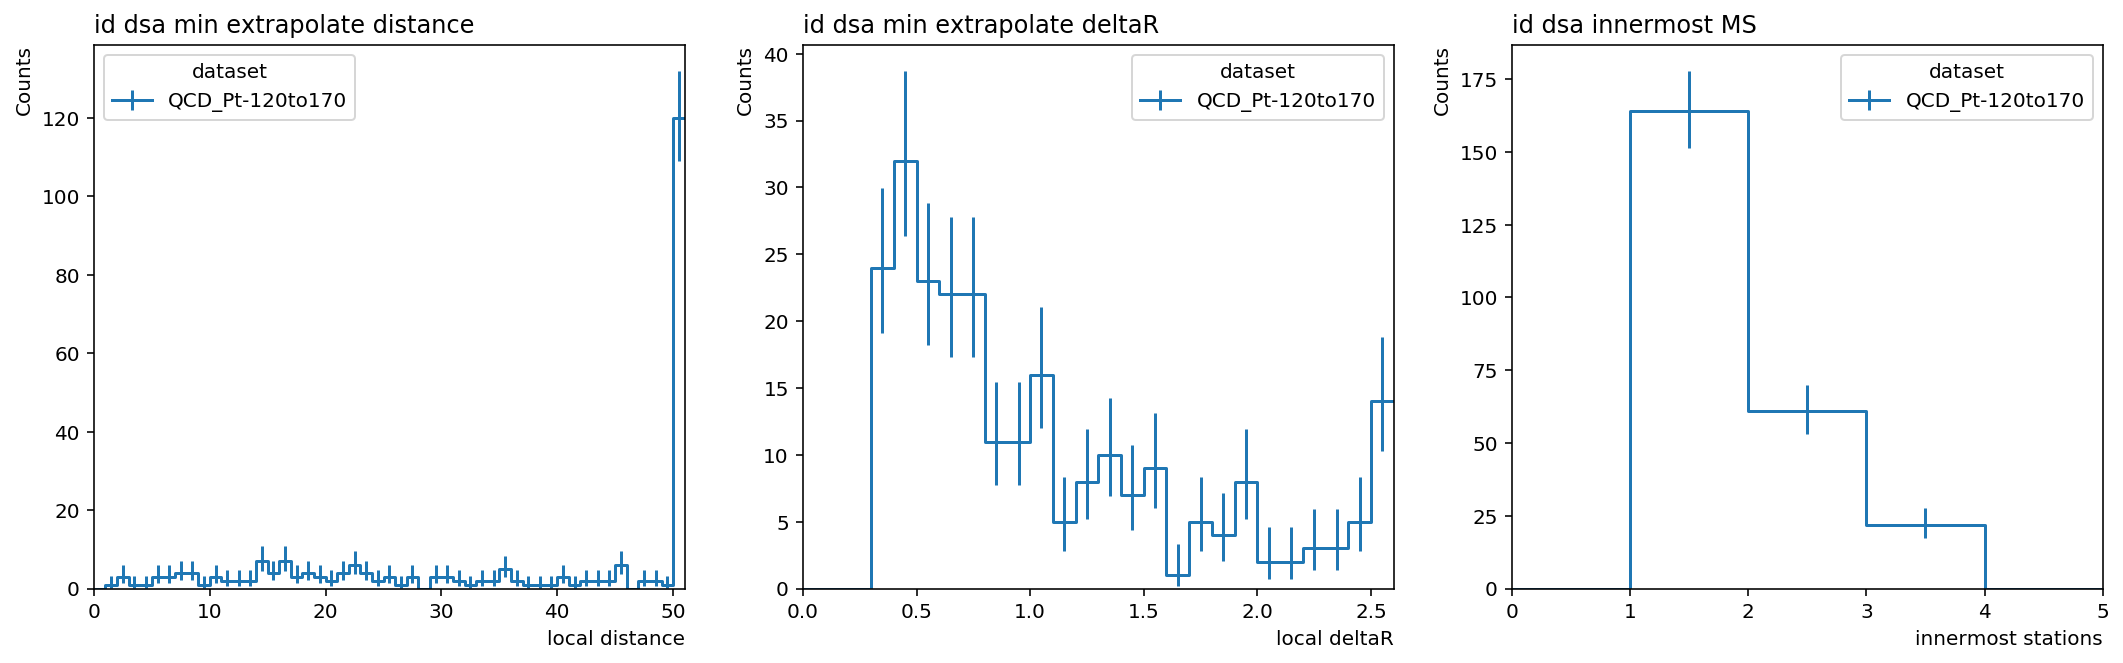

In [177]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
# hist.plot2d(output['dsalocal'].sum('dataset'), 'localdist', xoverflow='over', yoverflow='over', ax=ax, )
hist.plot1d(output['dsalocal'].sum('localdr', 'sta', overflow='all'), overlay='dataset', overflow='over', ax=axes[0])
hist.plot1d(output['dsalocal'].sum('localdist', 'sta', overflow='all'), overlay='dataset', overflow='over', ax=axes[1])
hist.plot1d(output['dsalocal'].sum('localdist', 'localdr', overflow='all'), overlay='dataset', overflow='over', ax=axes[2])

axes[0].set_title('id dsa min extrapolate distance', ha='left', x=0)
axes[1].set_title('id dsa min extrapolate deltaR', ha='left', x=0)
axes[2].set_title('id dsa innermost MS', ha='left', x=0)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### inspect unmatched dsa properties

In [184]:
class unmatcheddsaProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        ratio_axis = hist.Bin('ratio', 'max segment overlapping ratio', 10, 0, 1)
        dist_axis = hist.Bin('dr', 'min extrapolated distance', 25, 0, 5)
        eta_axis = hist.Bin('eta', '$\eta$', 48, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\Phi$', 50, -np.pi, np.pi)
        pterr_axis = hist.Bin('pterr', '$\sigma_{p_T}$', 25, 0, 25)
        derrdpt_axis = hist.Bin('derrdpt', '$\sigma_{p_T}/p_T$', 10, 0, 1)
        oot_axis = hist.Bin('oot', 'out of time', 2, 0, 2)
        fot_axis = hist.Bin('fot', 'find opposite track', 2, 0, 2)
        sta_axis = hist.Bin('nsta', 'number of MS', 4, 0, 4)
        self._accumulator = processor.dict_accumulator({
            'unmat_dsa': hist.Hist('Counts', dataset_axis, ratio_axis, dist_axis, eta_axis, phi_axis),
            'unmat_dsa2': hist.Hist('Counts', dataset_axis, pterr_axis, derrdpt_axis, oot_axis, fot_axis),
            'unmat_dsa3': hist.Hist('Counts', dataset_axis, sta_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['dsamuon_p4.fCoordinates.fX'],
                                                 df['dsamuon_p4.fCoordinates.fY'],
                                                 df['dsamuon_p4.fCoordinates.fZ'],
                                                 df['dsamuon_p4.fCoordinates.fT']),
            cschits=df['dsamuon_nValCSCHits'],
            dthits=df['dsamuon_nValDTHits'],
            cscstas=df['dsamuon_nValCSCStas'],
            dtstas=df['dsamuon_nValDTStas'],
            pterr=df['dsamuon_ptErr'],
            normchi2=df['dsamuon_normChi2'],
            maxoverlapratio=df['dsamuon_maxSegmentOverlapRatio'],
            minlocaldr=df['dsamuon_minExtrapolateInnermostLocalDr'],
            minglobaldr=df['dsamuon_minGlobalDeltaR'],
            oot=df['dsamuon_outOfTime'],
            fot=df['dsamuon_findOppositeTrack'],
        )
        dsamuons.add_attributes(derrdpt=(dsamuons.pterr/dsamuons.pt).flatten())
        dsaid=((dsamuons.cschits+dsamuons.dthits)>12)&((dsamuons.cscstas+dsamuons.dtstas)>1)&((dsamuons.pterr/dsamuons.pt)<1)
        dsamuons.add_attributes(dsaid=dsaid)
        ismatched = (dsamuons.maxoverlapratio>0.66)|((dsamuons.maxoverlapratio<=0.66)&(dsamuons.minlocaldr<0.3)|(dsamuons.minglobaldr<0.3))
        dsamuons.add_attributes(ismatched=ismatched)
        
        unmat_dsa = dsamuons[dsamuons.dsaid&(~dsamuons.ismatched)&(dsamuons.pt>10.)]
        
        
        
        output['unmat_dsa'].fill(dataset=dataset, ratio=unmat_dsa.maxoverlapratio.flatten(),
                                dr=unmat_dsa.minlocaldr.flatten(),
                                eta=unmat_dsa.eta.flatten(),
                                phi=unmat_dsa.phi.flatten(),
                                )
        output['unmat_dsa2'].fill(dataset=dataset, pterr=unmat_dsa.pterr.flatten(),
                                derrdpt=unmat_dsa.derrdpt.flatten(),
                                 oot=unmat_dsa.oot.flatten(),
                                 fot=unmat_dsa.fot.flatten())
        output['unmat_dsa3'].fill(dataset=dataset, nsta=(unmat_dsa.cscstas+unmat_dsa.dtstas).flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [185]:
dataset = backgrounds_['QCD']
output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=unmatcheddsaProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 118/118 [00:08<00:00, 13.67items/s]


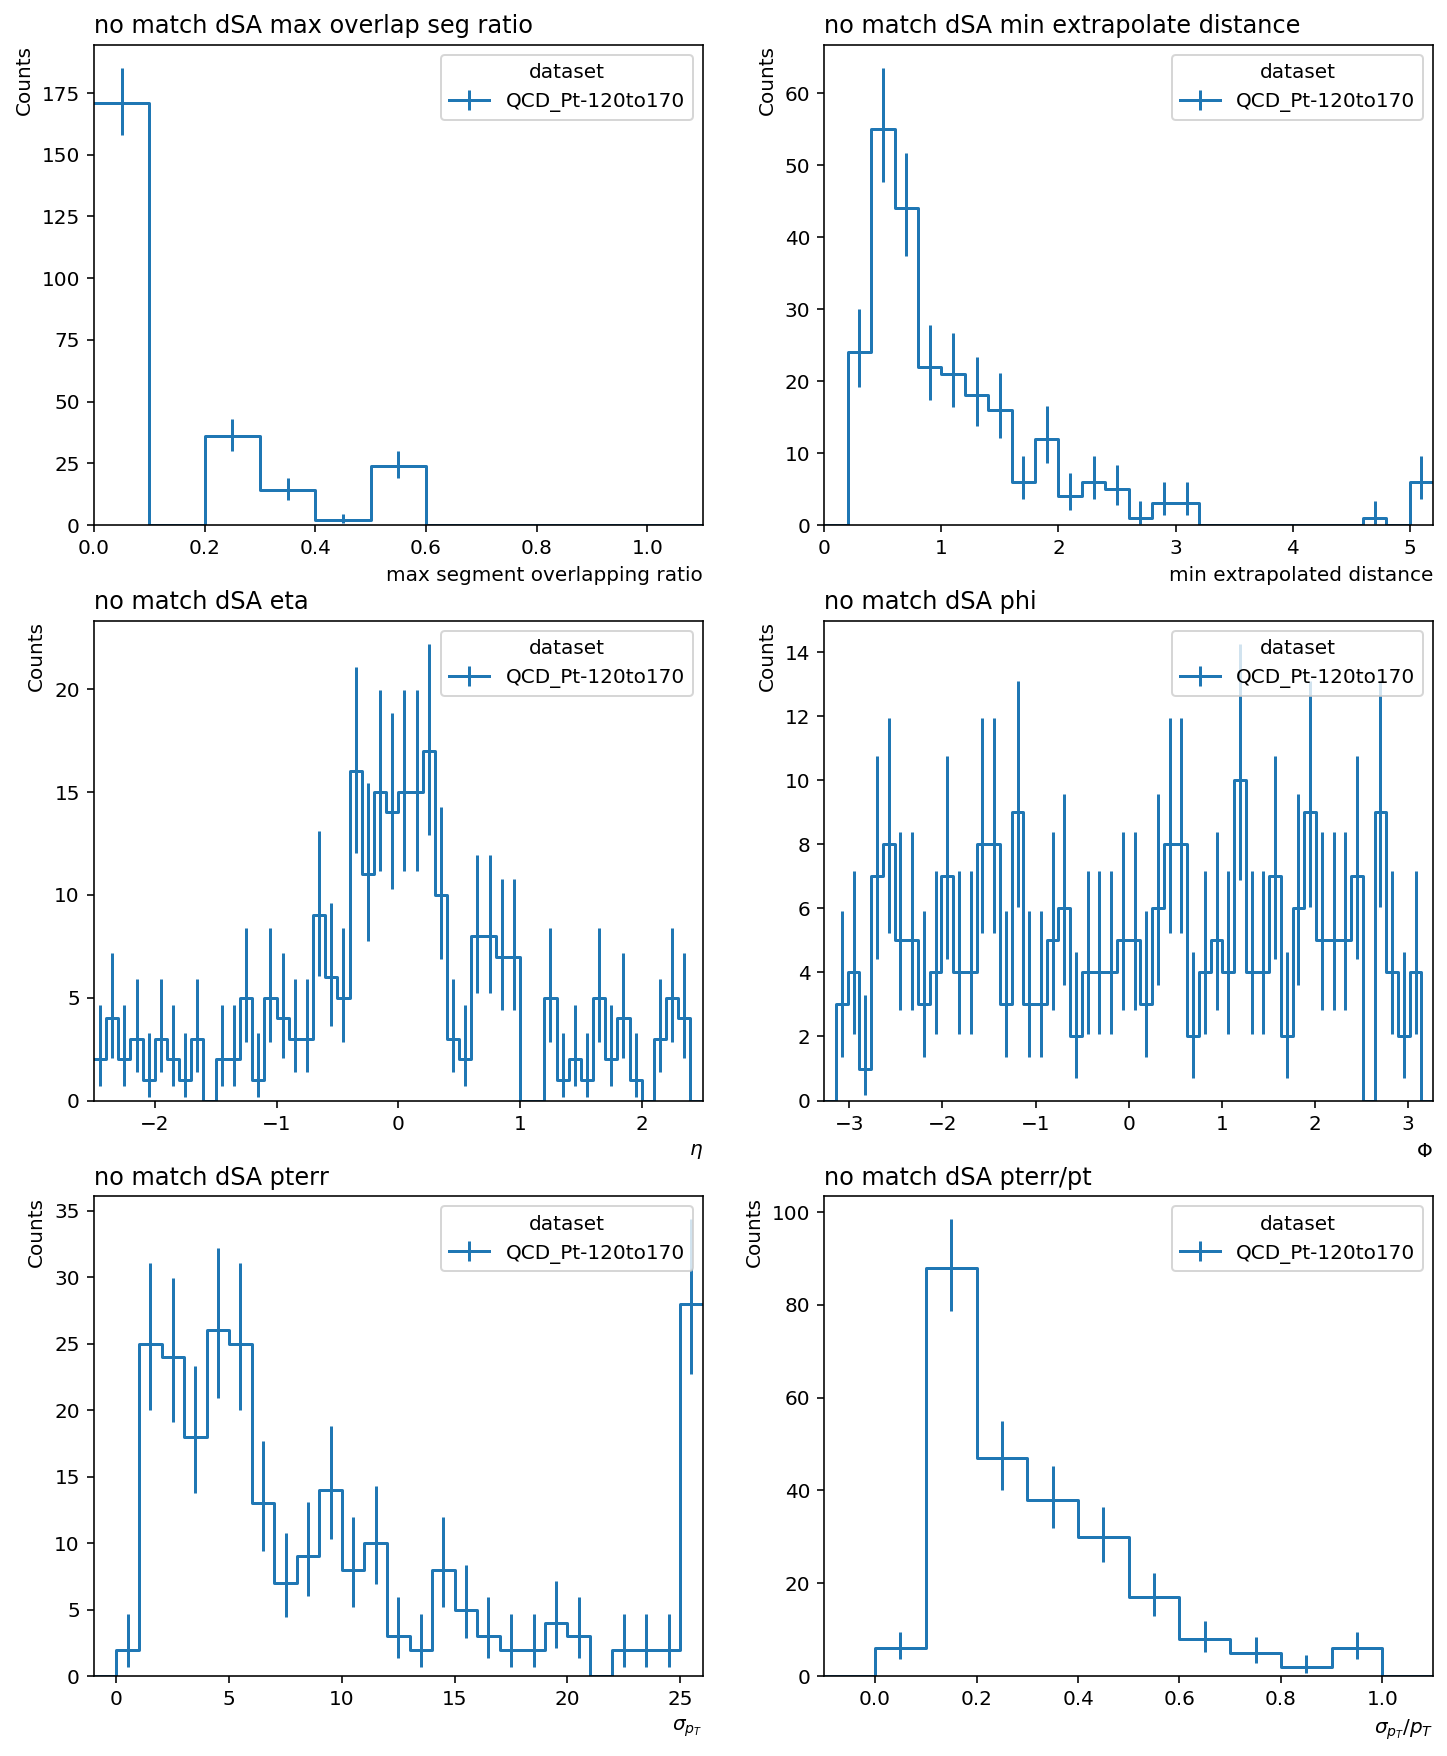

In [186]:
fig, axes = plt.subplots(3,2,figsize=(12,15))
hist.plot1d(output['unmat_dsa'].sum('dr', 'eta', 'phi', overflow='all'),
            overlay='dataset', overflow='over', ax=axes[0][0])
hist.plot1d(output['unmat_dsa'].sum('ratio', 'eta', 'phi', overflow='all'),
            overlay='dataset', overflow='over', ax=axes[0][1])
hist.plot1d(output['unmat_dsa'].sum('dr', 'ratio', 'phi', overflow='all'),
            overlay='dataset', overflow='all', ax=axes[1][0])
hist.plot1d(output['unmat_dsa'].sum('dr', 'ratio', 'eta', overflow='all'),
            overlay='dataset', overflow='all', ax=axes[1][1])

hist.plot1d(output['unmat_dsa2'].sum('derrdpt', 'oot', 'fot', overflow='all'),
            overlay='dataset', overflow='all', ax=axes[2][0])
hist.plot1d(output['unmat_dsa2'].sum('pterr', 'oot', 'fot', overflow='all'),
            overlay='dataset', overflow='all', ax=axes[2][1])

axes[0][0].set_title('no match dSA max overlap seg ratio', ha='left', x=0)
axes[0][1].set_title('no match dSA min extrapolate distance', ha='left', x=0)
axes[1][0].set_title('no match dSA eta', ha='left', x=0)
axes[1][1].set_title('no match dSA phi', ha='left', x=0)
axes[2][0].set_title('no match dSA pterr', ha='left', x=0)
axes[2][1].set_title('no match dSA pterr/pt', ha='left', x=0)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [187]:
print('OutOfTime', output['unmat_dsa2'].sum('pterr', 'derrdpt', 'fot', 'dataset', overflow='all').values()[()])
print('FindOppositeTrack', output['unmat_dsa2'].sum('pterr', 'derrdpt', 'oot', 'dataset', overflow='all').values()[()])

OutOfTime [200.  47.]
FindOppositeTrack [247.   0.]


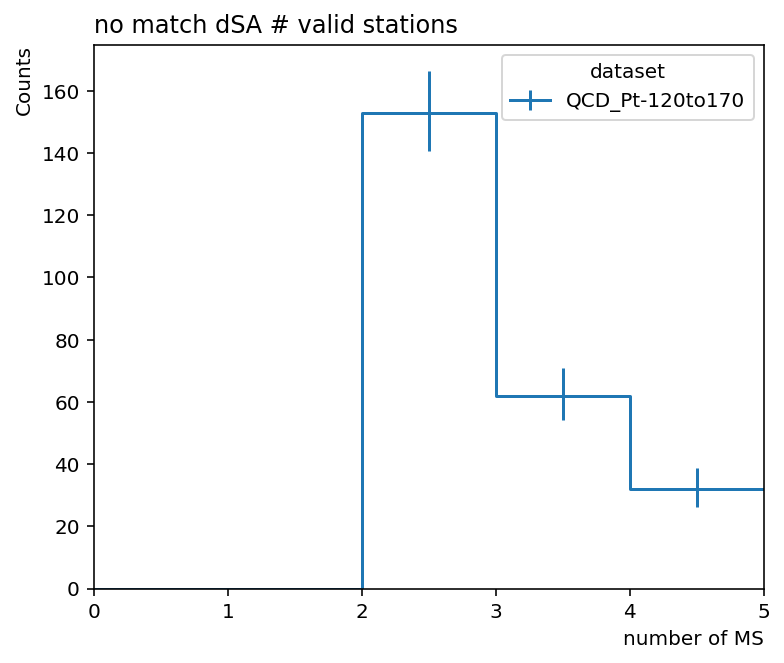

In [188]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['unmat_dsa3'], overlay='dataset', ax=ax, overflow='over')

ax.set_title('no match dSA # valid stations', ha='left', x=0)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

genmuons with Lxy>100cm, how many preserved (before/after matching)?

In [3]:
class sigmcCheckProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        self._accumulator = processor.dict_accumulator({
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
#         dsamuons = JaggedCandidateArray.candidatesfromcounts(
#             df['dsamuon_p4'],
#             p4=TLorentzVectorArray.from_cartesian(df['dsamuon_p4.fCoordinates.fX'],
#                                                  df['dsamuon_p4.fCoordinates.fY'],
#                                                  df['dsamuon_p4.fCoordinates.fZ'],
#                                                  df['dsamuon_p4.fCoordinates.fT']),
#             cschits=df['dsamuon_nValCSCHits'],
#             dthits=df['dsamuon_nValDTHits'],
#             cscstas=df['dsamuon_nValCSCStas'],
#             dtstas=df['dsamuon_nValDTStas'],
#             pterr=df['dsamuon_ptErr'],
#             normchi2=df['dsamuon_normChi2'],
#             maxoverlapratio=df['dsamuon_maxSegmentOverlapRatio'],
#             minlocaldr=df['dsamuon_minExtrapolateInnermostLocalDr'],
#             minglobaldr=df['dsamuon_minGlobalDeltaR'],
#             oot=df['dsamuon_outOfTime'],
#             fot=df['dsamuon_findOppositeTrack'],
#         )
#         dsamuons.add_attributes(derrdpt=(dsamuons.pterr/dsamuons.pt).flatten())
#         dsaid=((dsamuons.cschits+dsamuons.dthits)>12)&((dsamuons.cscstas+dsamuons.dtstas)>1)&((dsamuons.pterr/dsamuons.pt)<1)
#         dsamuons.add_attributes(dsaid=dsaid)
#         ismatched = (dsamuons.maxoverlapratio>0.66)|((dsamuons.maxoverlapratio<=0.66)&(dsamuons.minlocaldr<0.3))#|(dsamuons.minglobaldr<0.3))
#         dsamuons.add_attributes(ismatched=ismatched)
        
        ## recomuons/pfmuons
        recomuons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['muon_p4.fCoordinates.fX'],
                                                 df['muon_p4.fCoordinates.fY'],
                                                 df['muon_p4.fCoordinates.fZ'],
                                                 df['muon_p4.fCoordinates.fT']),
            ispfmuon=df['muon_isPFMuon'],
        )
        pfmuons = recomuons[recomuons.ispfmuon]
                
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
            vx=df['gen_vtx.fCoordinates.fX'],
            vy=df['gen_vtx.fCoordinates.fY'],
            vz=df['gen_vtx.fCoordinates.fZ'],
        )
        genparticles.add_attributes(vxy=np.hypot(genparticles.vx, genparticles.vy))
        
        genmuons = genparticles[(np.abs(genparticles.pid)==13)]
        
#         dsamuons.add_attributes(genmatchedidx = dsamuons.argmatch(genmuons, deltaRCut=0.2))
#         matcheddsa = dsamuons[dsamuons.genmatchedidx!=-1]
#         matcheddsa = matcheddsa[genmuons[matcheddsa.genmatchedidx].vxy>100]
        
#         output['cutflow']['genmatched'] += matcheddsa.counts.sum()
#         output['cutflow']['+dsaid'] += matcheddsa[matcheddsa.dsaid].counts.sum()
#         output['cutflow']['+innermatch'] += matcheddsa[matcheddsa.dsaid&matcheddsa.ismatched].counts.sum()

        genmuons = genmuons[genmuons.vxy<3]
        matchres = pfmuons.match(genmuons, deltaRCut=0.3)
#         matchres = matchres[genmuons.vxy>100]
        output['cutflow']['total'] += pfmuons.counts.sum()
        output['cutflow']['matched'] += matchres.flatten().sum()
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
# dataset={
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
# }

dataset={
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=sigmcCheckProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 10/10 [00:04<00:00,  2.50items/s]


In [5]:
pd.Series(dict(output['cutflow']))

total      251376
matched    101452
dtype: int64

In [7]:
class bkgmcCheckProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        self._accumulator = processor.dict_accumulator({
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ## recomuons/pfmuons
        recomuons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['muon_p4.fCoordinates.fX'],
                                                 df['muon_p4.fCoordinates.fY'],
                                                 df['muon_p4.fCoordinates.fZ'],
                                                 df['muon_p4.fCoordinates.fT']),
            ispfmuon=df['muon_isPFMuon'],
        )
        pfmuons = recomuons[recomuons.ispfmuon]
                
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
        )
        
        genmuons = genparticles[(np.abs(genparticles.pid)==13)]

        matchres = pfmuons.match(genmuons, deltaRCut=0.3)

        output['cutflow']['total'] += pfmuons.counts.sum()
        output['cutflow']['matched'] += matchres.flatten().sum()
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [8]:
dataset = backgrounds_['QCD']
output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=bkgmcCheckProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 118/118 [00:17<00:00,  6.93items/s]


In [9]:
pd.Series(dict(output['cutflow']))

total      249991
matched    116909
dtype: int64